<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Align-the-NIRCam-SMACS-0723-image" data-toc-modified-id="Align-the-NIRCam-SMACS-0723-image-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Align the NIRCam SMACS 0723 image</a></span></li></ul></div>

# Align the NIRCam SMACS 0723 image

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np

if not os.path.exists('52210366419_296e6fc745_o.png'):
    os.system('wget https://live.staticflickr.com/65535/52210366419_296e6fc745_o.png')


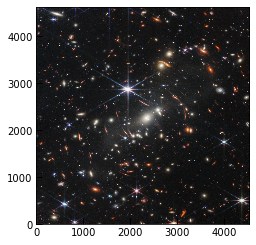

In [10]:
img = np.flipud(plt.imread('52210366419_296e6fc745_o.png'))
plt.imshow(img)

In [3]:
from grizli import prep
gaia = prep.get_gaia_DR2_vizier(ra=110.83403, dec=-73.45429, radius=5)
rd = prep.get_gaia_radec_at_time(gaia, date='2022-07-01', format='iso')
ok = np.isfinite(rd.ra.deg + rd.dec.deg)
gaia['ra'] = rd.ra.deg
gaia['dec'] = rd.dec.deg
gaia = gaia[ok]
prep.table_to_regions(gaia, 'smacs0723_gaia.reg')
prep.table_to_radec(gaia, 'smacs0723_gaia.radec')


2022-07-12 01:38:07,011 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/erfa/core.py:4991: RuntimeWarning: invalid value encountered in pmsafe
  ra2, dec2, pmr2, pmd2, px2, rv2, c_retval = ufunc.pmsafe(

2022-07-12 01:38:07,012 - stpipe - WARNING - /Users/gbrammer/miniconda3/envs/py39-may10/lib/python3.9/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "pmsafe" yielded 22 of "solution didn't converge (Note 8)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),



smacs0723_gaia.reg: x = ra, y=dec, ellipse=False


In [4]:
sci = np.cast[int](np.round((img*1.).sum(axis=2)))
sci


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 0, 1, 0],
       [2, 2, 2, ..., 0, 1, 0],
       [2, 2, 2, ..., 0, 0, 0]])

In [5]:
import sep
import astropy.io.fits as pyfits

#sci = (img*2**12).sum(axis=2).astype(int)
sci = (img).sum(axis=2)
bkg = sep.Background(sci*1.)

ivar = 1./bkg.rms()**2



In [6]:
sci.shape, sci.dtype

((4630, 4537), dtype('float32'))

In [7]:
from grizli import utils
pscale = 0.03
h, wcs = utils.make_wcsheader(ra=110.8343, dec=-73.45429, pixscale=pscale, size=np.array(sci.shape)*pscale,
                              theta=35, 
                          )

h['CRPIX1'] = 2725.8161
h['CRPIX2'] = 2404.5448
h['CRVAL1'] = 110.8154056
h['CRVAL2'] = -73.4554872
h['INSTRUME'] = 'NIRCAM'
h['TELESCOP'] = 'JWST'
h['PHOTFNU'] = 1.e-6
h['FILTER'] = 'F200W'
h['PUPIL'] = 'CLEAR'

pyfits.writeto('smacs0723-nircam-png_drz_sci.fits', data=sci, overwrite=True, header=h, output_verify='fix')
pyfits.writeto('smacs0723-nircam-png_drz_wht.fits', data=ivar, overwrite=True, header=h, output_verify='fix')

2022-07-12 01:38:08,190 - stpipe - WARNING - VerifyWarning: Verification reported errors:
2022-07-12 01:38:08,198 - stpipe - WARNING - VerifyWarning: HDU 0:
2022-07-12 01:38:08,202 - stpipe - WARNING - VerifyWarning:     'NAXIS1' card at the wrong place (card 11).  Fixed by moving it to the right place (card 3).
2022-07-12 01:38:08,206 - stpipe - WARNING - VerifyWarning:     'NAXIS2' card at the wrong place (card 12).  Fixed by moving it to the right place (card 4).
 [astropy.io.fits.verify]
2022-07-12 01:38:08,210 - stpipe - WARNING - VerifyWarning: Note: astropy.io.fits uses zero-based indexing.



In [8]:
from skimage.transform import SimilarityTransform
for iter in range(2):
    _ = prep.align_drizzled_image('smacs0723-nircam-png', radec='smacs0723_gaia.radec') #, transform=SimilarityTransform)

    wnew = _[1]
    hnew = utils.to_header(wnew)
    for k in hnew:
        h[k] = hnew[k]

    pyfits.writeto('smacs0723-nircam-png_drz_sci.fits', data=sci, overwrite=True, header=h, output_verify='fix')
    pyfits.writeto('smacs0723-nircam-png_drz_wht.fits', data=ivar, overwrite=True, header=h, output_verify='fix')

# (2022-07-11 23:38:08.952)

prep.align_drizzled_image(**{'root': 'smacs0723-nircam-png', 'mag_limits': [14, 23], 'radec': 'smacs0723_gaia.radec', 'NITER': 3, 'clip': 20, 'log': True, 'outlier_threshold': 5, 'verbose': True, 'guess': [0.0, 0.0, 0.0, 1], 'simple': True, 'rms_limit': 2, 'use_guess': False, 'triangle_size_limit': [5, 1800], 'max_sources': 200, 'triangle_ba_max': 0.9, 'max_err_percentile': 99, 'catalog_mask_pad': 0.05, 'min_flux_radius': 1.0, 'match_catalog_density': None, 'assume_close': False, 'ref_border': 100, 'transform': None})

# wcs smacs0723-nircam-png radec="smacs0723_gaia.radec"; Ncat=48; Nref=24
# wcs smacs0723-nircam-png (guess)   :   0.00   0.00   0.000   1.000
  tristars.match: Nin=7, Nout=7, match=4
# wcs smacs0723-nircam-png (0) 4:  -0.47  -3.38  -0.073   1.000
  tristars.match: Nin=7, Nout=7, match=4
# wcs smacs0723-nircam-png (1) 4:   0.00  -0.00  -0.000   1.000
  tristars.match: Nin=7, Nout=7, match=4
# wcs smacs0723-nircam-png (2) 4:   0.00   0.00   0.

In [9]:
hnew

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =            2725.8161 / Pixel coordinate of reference point            
CRPIX2  =            2404.5448 / Pixel coordinate of reference point            
CD1_1   = -6.8323829869038E-06 / Coordinate transformation matrix element       
CD1_2   = -4.7710572376266E-06 / Coordinate transformation matrix element       
CD2_1   = -4.7710572376265E-06 / Coordinate transformation matrix element       
CD2_2   =  6.8323829869039E-06 / Coordinate transformation matrix element       
CDELT1  =                  1.0 / [deg] Coordinate increment at reference point  
CDELT2  =                  1.0 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'        